In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms as T 

from PIL import Image

from skimage.morphology import flood, area_closing
from skimage.segmentation import slic, mark_boundaries, watershed, inverse_gaussian_gradient, find_boundaries
from skimage.util import img_as_float
from skimage import filters
from skimage.feature import blob_dog, canny


from skimage.measure import find_contours,  approximate_polygon

from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [2]:
# load pretrained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
mrcnn_model = maskrcnn_resnet50_fpn(weights=weights, progress=False).to(device)
mrcnn_model = mrcnn_model.eval()

In [3]:
# load image, conver to tensor
img = Image.open('./coral4.jpg')
transform = T.Compose([T.ToTensor()]) 
img = transform(img)
# pred = mrcnn_model([img])

In [4]:
# create forward hook to get output of intermediate later
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

In [5]:
mrcnn_model.backbone.body.layer1.register_forward_hook(get_activation('backbone'))
pred = mrcnn_model([img])

In [6]:
activation['backbone']

tensor([[[[1.6627e-01, 1.1977e-01, 9.6517e-02,  ..., 2.8018e-02,
           8.0000e-02, 9.0309e-02],
          [1.5393e-01, 1.3626e-01, 8.8864e-02,  ..., 3.9399e-02,
           4.0213e-02, 6.5786e-02],
          [1.3605e-01, 1.3157e-01, 9.2284e-02,  ..., 8.1305e-02,
           7.8877e-02, 4.6645e-02],
          ...,
          [1.6788e-01, 1.6968e-01, 1.9480e-01,  ..., 1.4203e-01,
           1.8643e-01, 1.6463e-01],
          [1.6664e-01, 2.4726e-01, 2.2567e-01,  ..., 1.7595e-01,
           1.6887e-01, 1.0592e-01],
          [1.2254e-01, 1.9293e-01, 1.9941e-01,  ..., 1.7594e-01,
           1.3488e-01, 6.5216e-02]],

         [[1.7916e-01, 1.8785e-01, 1.9349e-01,  ..., 1.7250e-01,
           2.3123e-01, 2.3091e-01],
          [1.8044e-01, 1.7691e-01, 1.7435e-01,  ..., 1.7482e-01,
           2.0314e-01, 1.9647e-01],
          [1.6807e-01, 1.6432e-01, 1.5718e-01,  ..., 1.5383e-01,
           1.6945e-01, 1.5066e-01],
          ...,
          [3.7347e-01, 3.9480e-01, 3.4168e-01,  ..., 2.0857

In [7]:
img.shape

torch.Size([3, 500, 500])

In [8]:
# get backbone convolution layers and weights

model_weights =[]
conv_layers = []
model_children = list(mrcnn_model.backbone.body.children())

counter = 0

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 49
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False), Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False), Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [9]:
# get feature map of each layer
outputs = []
names = []
for layer in conv_layers:
    img = layer(img)
    outputs.append(img)
    names.append(str(layer))
print(len(outputs))

for feature_map in outputs:
    print(feature_map.shape)

49
torch.Size([64, 250, 250])
torch.Size([64, 250, 250])
torch.Size([64, 250, 250])
torch.Size([256, 250, 250])
torch.Size([64, 250, 250])
torch.Size([64, 250, 250])
torch.Size([256, 250, 250])
torch.Size([64, 250, 250])
torch.Size([64, 250, 250])
torch.Size([256, 250, 250])
torch.Size([128, 250, 250])
torch.Size([128, 125, 125])
torch.Size([512, 125, 125])
torch.Size([128, 125, 125])
torch.Size([128, 125, 125])
torch.Size([512, 125, 125])
torch.Size([128, 125, 125])
torch.Size([128, 125, 125])
torch.Size([512, 125, 125])
torch.Size([128, 125, 125])
torch.Size([128, 125, 125])
torch.Size([512, 125, 125])
torch.Size([256, 125, 125])
torch.Size([256, 63, 63])
torch.Size([1024, 63, 63])
torch.Size([256, 63, 63])
torch.Size([256, 63, 63])
torch.Size([1024, 63, 63])
torch.Size([256, 63, 63])
torch.Size([256, 63, 63])
torch.Size([1024, 63, 63])
torch.Size([256, 63, 63])
torch.Size([256, 63, 63])
torch.Size([1024, 63, 63])
torch.Size([256, 63, 63])
torch.Size([256, 63, 63])
torch.Size([1024, 

In [10]:
# make feature maps 2D for plt
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.max(feature_map,0).values
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(250, 250)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(125, 125)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(63, 63)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


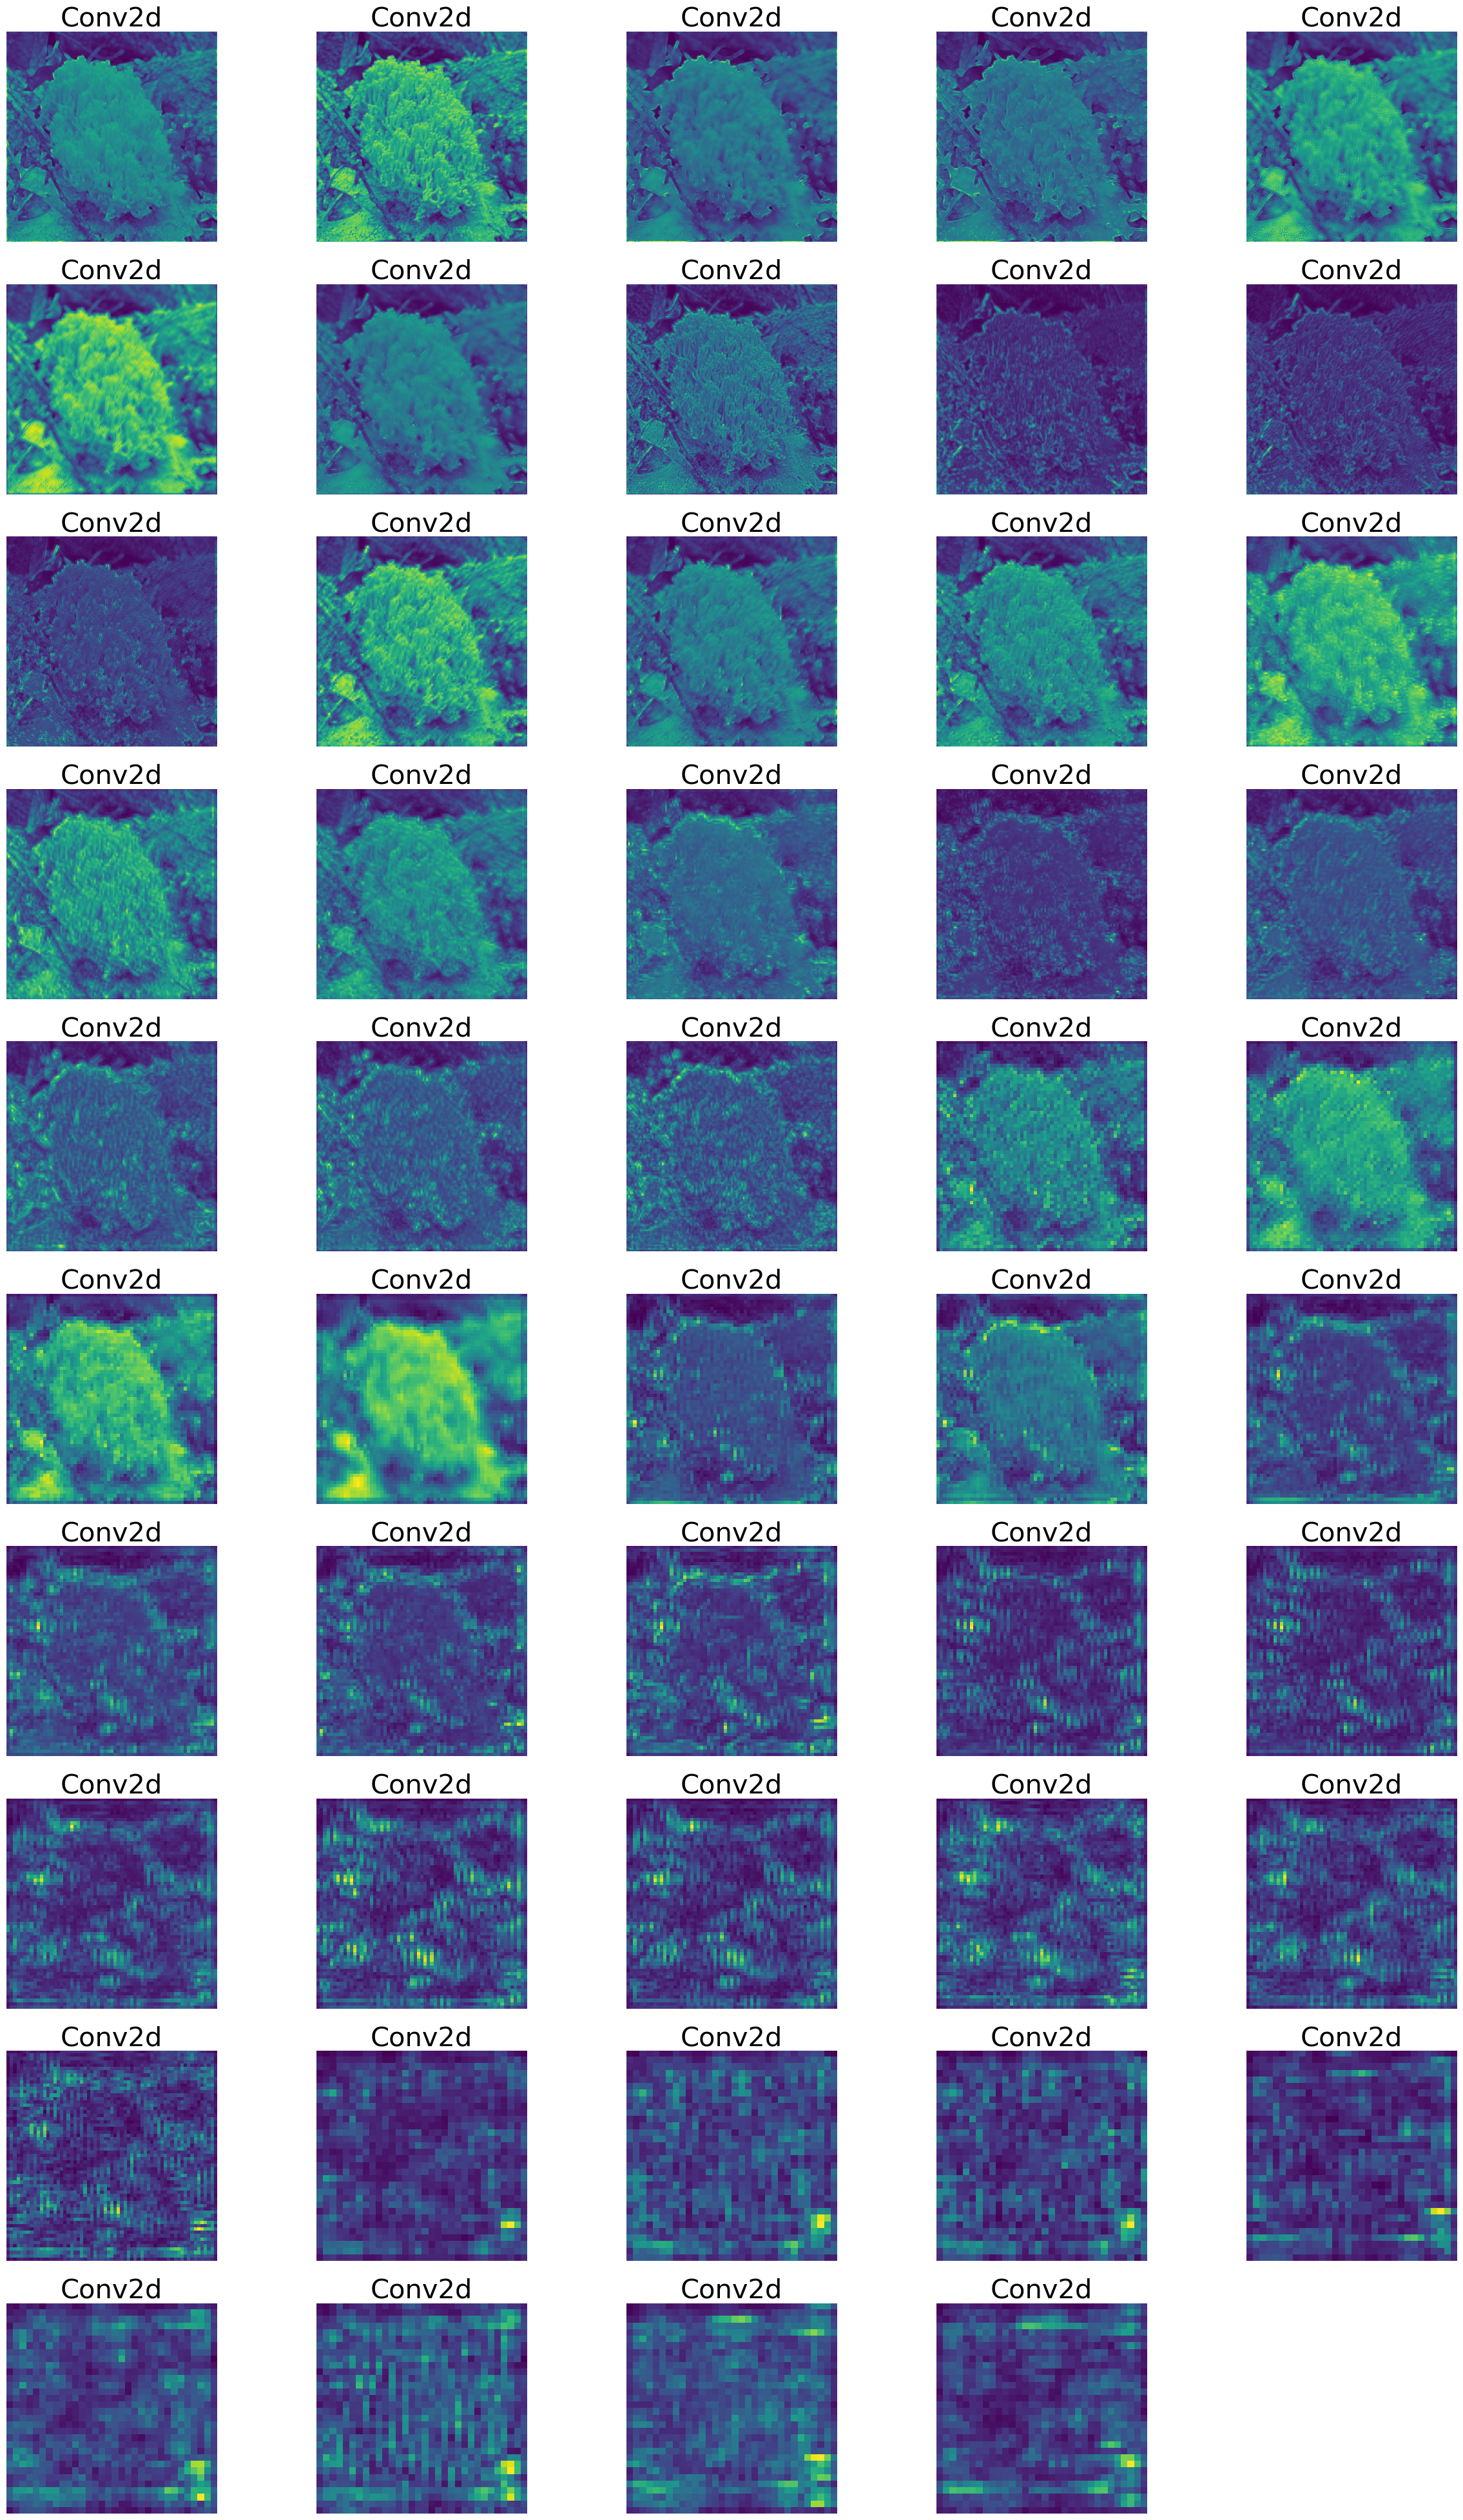

In [11]:
# visualize feature maps
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(10, 5, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [12]:
fm = outputs[3]
fm = fm.unsqueeze(0)
m = nn.Upsample((500, 500), mode='bicubic')
fm = m(fm)
fm = fm.squeeze(0)
fm = fm.data.cpu().numpy()

In [13]:
fm_max = np.max(fm, 0)

In [14]:
fm_s = filters.sobel(fm_max)

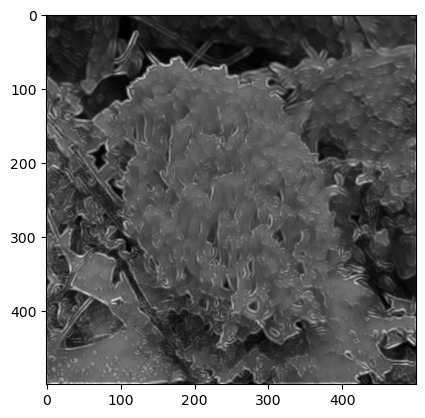

In [15]:
plt.imshow(fm_max, cmap='gray')

In [100]:
water_edges = flood(fm_max, (250, 250), tolerance=0.2)

In [130]:
boundaries = find_boundaries(water_edges,mode='inner')

[[[113 211]]

 [[113 213]]

 [[112 214]]

 ...

 [[114 218]]

 [[114 217]]

 [[113 216]]]


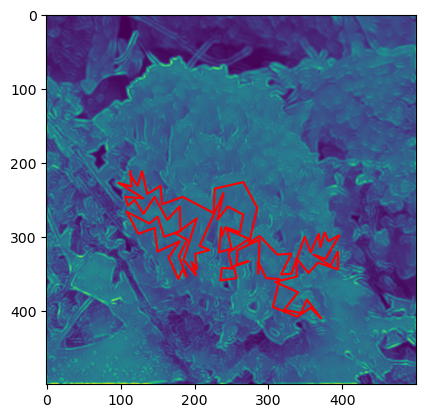

In [135]:
contours, hierarchy = cv2.findContours((boundaries * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    largest_contour = max(contours, key=cv2.contourArea)
    
    print(largest_contour)

    polygon = largest_contour.reshape(-1, 2)
    
    polygon = approximate_polygon(polygon, tolerance=10)

    plt.figure()
    plt.plot(polygon[:, 0], polygon[:, 1], 'r')
    plt.imshow(fm_max)
    plt.show()

In [136]:
len(polygon)

103

In [19]:
coral = img_as_float(Image.open('./coral4.jpg'))

In [103]:
import cv2

In [108]:
len(polygon)

2849